The data is long and thin.
I will make it analysis ready in MLtable format 

In [1]:
#%pip install python-dotenv -U

In [11]:
import numpy as np
import pandas as pd
from dotenv import load_dotenv
pd.set_option('display.float_format', '{:.2f}'.format)
from sklearn.model_selection import train_test_split
from azureml.core import Workspace
from azure.ai.ml import MLClient
from azure.identity import DefaultAzureCredential
from azure.ai.ml.entities import Data
from azure.ai.ml.constants import AssetTypes
import mltable
from mltable import MLTableHeaders, MLTableFileEncoding, DataType

In [12]:
def create_folder_if_not_exists(folder_path):
    """
    Creates a folder if it doesn't exist.

    Args:
        folder_path (str): The path to the folder.

    Returns:
        None
    """
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
        print(f"Folder '{folder_path}' created successfully.")
    else:
        print(f"Folder '{folder_path}' already exists.")

In [13]:
raw_df = pd.read_csv("../../../demo_data/PLACES__Local_Data_for_Better_Health__County_Data_2023_release_20240624.csv")
#Location ID 59 United States. drop it form the data
raw_df = raw_df[raw_df['LocationID']> 59]
raw_df['MeasureId_type'] = raw_df['MeasureId']+'_'+raw_df['DataValueTypeID']
raw_df.head()

,Year,StateAbbr,StateDesc,LocationName,DataSource,Category,Measure,Data_Value_Unit,Data_Value_Type,Data_Value,...,Low_Confidence_Limit,High_Confidence_Limit,TotalPopulation,LocationID,CategoryID,MeasureId,DataValueTypeID,Short_Question_Text,Geolocation,MeasureId_type
0,2021,AR,Arkansas,Conway,BRFSS,Health Outcomes,Arthritis among adults aged >=18 years,%,Crude prevalence,33.90,...,29.10,38.80,20873,5029,HLTHOUT,ARTHRITIS,CrdPrv,Arthritis,POINT (-92.6892479 35.265702),ARTHRITIS_CrdPrv
1,2020,AZ,Arizona,Maricopa,BRFSS,Prevention,Mammography use among women aged 50-74 years,%,Crude prevalence,69.00,...,65.50,72.30,4496588,4013,PREVENT,MAMMOUSE,CrdPrv,Mammography,POINT (-112.4989296 33.3451756),MAMMOUSE_CrdPrv
2,2021,AR,Arkansas,Jackson,BRFSS,Health Outcomes,Obesity among adults aged >=18 years,%,Crude prevalence,40.10,...,32.50,47.80,16811,5067,HLTHOUT,OBESITY,CrdPrv,Obesity,POINT (-91.2232051 35.5964674),OBESITY_CrdPrv
3,2020,CA,California,Alameda,BRFSS,Health Outcomes,All teeth lost among adults aged >=65 years,%,Crude prevalence,6.70,...,4.80,9.20,1648556,6001,HLTHOUT,TEETHLOST,CrdPrv,All Teeth Lost,POINT (-121.912488 37.6471385),TEETHLOST_CrdPrv
4,2021,AR,Arkansas,Ashley,BRFSS,Health Outcomes,Depression among adults aged >=18 years,%,Crude prevalence,25.40,...,21.30,30.00,18674,5003,HLTHOUT,DEPRESSION,CrdPrv,Depression,POINT (-91.7722672 33.1908354),DEPRESSION_CrdPrv


In [14]:
measure_table = raw_df['MeasureId'].value_counts().reset_index()
measure_table.columns = ['MeasureId', 'Count']
measure_table = measure_table.sort_values('MeasureId')
measure_table = measure_table.reset_index(drop=True)
print(measure_table)

       MeasureId  Count
0        ACCESS2   6152
1      ARTHRITIS   6152
2          BINGE   6152
3         BPHIGH   6152
4          BPMED   6152
5         CANCER   6152
6        CASTHMA   6152
7       CERVICAL   6286
8            CHD   6152
9        CHECKUP   6152
10    CHOLSCREEN   6152
11     COGNITION   6152
12  COLON_SCREEN   6286
13          COPD   6152
14         COREM   6286
15         COREW   6286
16      CSMOKING   6152
17        DENTAL   6286
18    DEPRESSION   6152
19      DIABETES   6152
20    DISABILITY   6152
21         GHLTH   6152
22       HEARING   6152
23      HIGHCHOL   6152
24     INDEPLIVE   6152
25        KIDNEY   6152
26           LPA   6152
27      MAMMOUSE   6286
28         MHLTH   6152
29      MOBILITY   6152
30       OBESITY   6152
31         PHLTH   6152
32      SELFCARE   6152
33         SLEEP   6286
34        STROKE   6152
35     TEETHLOST   6286
36        VISION   6152


count      3143.00
mean     105597.76
std      333049.86
min          57.00
25%       10828.00
50%       25787.00
75%       68523.50
max     9829544.00
Name: TotalPopulation, dtype: float64
      LocationID LocationName StateAbbr StateDesc  TotalPopulation
0           1001      Autauga        AL   Alabama            59095
1           1003      Baldwin        AL   Alabama           239294
2           1005      Barbour        AL   Alabama            24964
3           1007         Bibb        AL   Alabama            22477
4           1009       Blount        AL   Alabama            59041
...          ...          ...       ...       ...              ...
3138       56037   Sweetwater        WY   Wyoming            41614
3139       56039        Teton        WY   Wyoming            23575
3140       56041        Uinta        WY   Wyoming            20635
3141       56043     Washakie        WY   Wyoming             7705
3142       56045       Weston        WY   Wyoming             6745

[3143

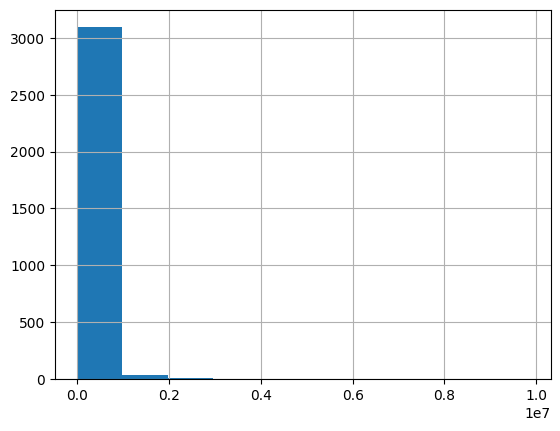

In [15]:
#I thought the populations number would be differnet for each year - that is not the case.
Locations = raw_df.groupby(['LocationID','LocationName','StateAbbr','StateDesc']).first().reset_index()
Locations = Locations[['LocationID','LocationName','StateAbbr','StateDesc', 'TotalPopulation']]
Locations = Locations.sort_values(['LocationID','LocationName','StateAbbr','StateDesc'])
Locations = Locations.reset_index(drop=True)
print(Locations.TotalPopulation.describe())
Locations.TotalPopulation.hist()
print(Locations)

In [16]:
# Pivot the table 
# looks like one year one set of values was measured and on the other a differnt set so no nee to pivot on year
pivoted_df = raw_df.pivot(index=['LocationID'], 
                          columns='MeasureId_type', 
                          values='Data_Value')

# Reset the index to make 'LocationID' and 'Year' regular columns
pivoted_df = pivoted_df.reset_index()
pivoted_df = pivoted_df.sort_values(['LocationID'])
pivoted_df = pivoted_df.reset_index(drop=True)

print(pivoted_df.head())
print("\nNew table info:")
print(pivoted_df.info())

MeasureId_type  LocationID  ACCESS2_AgeAdjPrv  ACCESS2_CrdPrv  \
0                     1001              10.40           10.00   
1                     1003               9.50            8.90   
2                     1005              17.20           16.70   
3                     1007              14.30           14.00   
4                     1009              13.10           12.50   

MeasureId_type  ARTHRITIS_AgeAdjPrv  ARTHRITIS_CrdPrv  BINGE_AgeAdjPrv  \
0                             28.20             31.60            15.50   
1                             26.40             32.70            17.80   
2                             30.60             35.40            13.40   
3                             29.50             32.70            15.40   
4                             28.40             33.30            16.00   

MeasureId_type  BINGE_CrdPrv  BPHIGH_AgeAdjPrv  BPHIGH_CrdPrv  \
0                      14.40             37.20          40.70   
1                      15.30      

In [17]:
data_mart = pd.merge(Locations, pivoted_df, on='LocationID', how='left')
# Drop rows with any NaN values
data_mart = data_mart.dropna()

data_mart = data_mart.sort_values(['LocationID'])
data_mart = data_mart.reset_index(drop=True)

print(data_mart.head())
print("\nMerged table info:")
print(data_mart.info())

   LocationID LocationName StateAbbr StateDesc  TotalPopulation  \
0        1001      Autauga        AL   Alabama            59095   
1        1003      Baldwin        AL   Alabama           239294   
2        1005      Barbour        AL   Alabama            24964   
3        1007         Bibb        AL   Alabama            22477   
4        1009       Blount        AL   Alabama            59041   

   ACCESS2_AgeAdjPrv  ACCESS2_CrdPrv  ARTHRITIS_AgeAdjPrv  ARTHRITIS_CrdPrv  \
0              10.40           10.00                28.20             31.60   
1               9.50            8.90                26.40             32.70   
2              17.20           16.70                30.60             35.40   
3              14.30           14.00                29.50             32.70   
4              13.10           12.50                28.40             33.30   

   BINGE_AgeAdjPrv  ...  SELFCARE_AgeAdjPrv  SELFCARE_CrdPrv  SLEEP_AgeAdjPrv  \
0            15.50  ...                3.

In [18]:
# Calculate the ratio of NaN values for each column
nan_ratios = data_mart.isnull().mean().sort_values(ascending=False)

# Convert to percentage and round to 2 decimal places
nan_percentages = (nan_ratios * 100).round(2)

# Create a DataFrame with the results
nan_summary = pd.DataFrame({
    'NaN Ratio': nan_ratios,
    'NaN Percentage': nan_percentages
})

print(nan_summary['NaN Percentage'].describe())
print(nan_summary[nan_summary['NaN Ratio'] > 0.01])

# Display the summary, showing only columns with NaN values
#print("Columns with NaN values (sorted by percentage):")
#print(nan_summary[nan_summary['NaN Ratio'] > 0])

# Identify the column with the highest NaN ratio
max_nan_column = nan_ratios.index[0]
max_nan_percentage = nan_percentages[0]

#print(f"\nColumn with the highest ratio of NaN values:")
#print(f"{max_nan_column}: {max_nan_percentage}%")

count   79.00
mean     0.00
std      0.00
min      0.00
25%      0.00
50%      0.00
75%      0.00
max      0.00
Name: NaN Percentage, dtype: float64
Empty DataFrame
Columns: [NaN Ratio, NaN Percentage]
Index: []


/tmp/ipykernel_2320727/233594821.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  max_nan_percentage = nan_percentages[0]


Data Mart Ready - now split and create MLTABLE

In [19]:
#I am having issues with the string variables not including them in the training but yes in the data given to RAI;

data_mart = data_mart.drop(labels=["LocationID","LocationName","StateAbbr","StateDesc","STROKE_CrdPrv","TotalPopulation"], axis="columns")

In [20]:
# Split the data into train and test sets
train_df, test_df = train_test_split(data_mart, test_size=0.3, random_state=42)

# Print the shapes of the train and test sets
print("Train set shape:", train_df.shape)
print("Test set shape:", test_df.shape)

print("writting to csv")
create_folder_if_not_exists('../../../demo_data/health/')
train_df.to_csv('../../../demo_data/health/train_csv.csv', index=False)
test_df.to_csv('../../../demo_data/health/test_csv.csv', index=False)

Train set shape: (2153, 73)
Test set shape: (923, 73)
writting to csv
Folder '../../../demo_data/health/' already exists.


In [22]:
"""
exclude_features_str = '"LocationID","LocationName","StateAbbr","StateDesc","STROKE_CrdPrv"'
exclude_features_list = list(exclude_features_str.strip('"').split('","'))
print(exclude_features_list)
temp_df = train_df.drop(labels=exclude_features_list, axis="columns")
print(temp_df.columns)
"""

'\nexclude_features_str = \'"LocationID","LocationName","StateAbbr","StateDesc","STROKE_CrdPrv"\'\nexclude_features_list = list(exclude_features_str.strip(\'"\').split(\'","\'))\nprint(exclude_features_list)\ntemp_df = train_df.drop(labels=exclude_features_list, axis="columns")\nprint(temp_df.columns)\n'

In [23]:
ws = Workspace.from_config()
datastore = ws.get_default_datastore()

datastore.upload_files(files=["../../../demo_data/health/train_csv.csv"],
                       target_path="/health/train_csv.csv",
                       overwrite=True)

datastore.upload_files(files=["../../../demo_data/health/test_csv.csv"],
                       target_path="/health/test_csv.csv",
                       overwrite=True)


"datastore.upload_files" is deprecated after version 1.0.69. Please use "FileDatasetFactory.upload_directory" instead. See Dataset API change notice at https://aka.ms/dataset-deprecation.


Uploading an estimated of 1 files
Uploading ../../../demo_data/health/train_csv.csv
Uploaded ../../../demo_data/health/train_csv.csv, 1 files out of an estimated total of 1
Uploaded 1 files
Uploading an estimated of 1 files
Uploading ../../../demo_data/health/test_csv.csv
Uploaded ../../../demo_data/health/test_csv.csv, 1 files out of an estimated total of 1
Uploaded 1 files


$AZUREML_DATAREFERENCE_4e10cb8cadfd40f2959f6094b966eae5

In [24]:
#The compoenents expect mltalbes so need firt to save to either csv or parquet
print("creating mltables")

train_paths = [{"file": "azureml://subscriptions/e02ff02a-3d3d-4fa7-828d-54c7d1f4899f/resourcegroups/aauki_eli_demos/workspaces/aauki_eli_demos_amlws01/datastores/workspaceblobstore/paths/health/train_csv.csv/train_csv.csv"}]
train_mltable = mltable.from_delimited_files(
    paths=train_paths,
    delimiter=",",
    header=MLTableHeaders.all_files_same_headers,
    infer_column_types=True,
    include_path_column=False,
    encoding=MLTableFileEncoding.utf8,
)

#train_mltable = train_mltable.convert_column_types(data_types)
train_mltable.show(5)

create_folder_if_not_exists('../../../demo_data/health_train_mltalbe/')
train_mltable.save("../../../demo_data/health_train_mltalbe") 



creating mltables
Folder '../../../demo_data/health_train_mltalbe/' already exists.


paths:
- file: azureml://subscriptions/e02ff02a-3d3d-4fa7-828d-54c7d1f4899f/resourcegroups/aauki_eli_demos/workspaces/aauki_eli_demos_amlws01/datastores/workspaceblobstore/paths/health/train_csv.csv/train_csv.csv
transformations:
- read_delimited:
    delimiter: ','
    empty_as_string: false
    encoding: utf8
    header: all_files_same_headers
    include_path_column: false
    infer_column_types: true
    partition_size: 20971520
    path_column: Path
    support_multi_line: false
type: mltable

In [25]:
#The compoenents expect mltalbes so need firt to save to either csv or parquet
print("creating mltables")

test_paths = [{"file": "azureml://subscriptions/e02ff02a-3d3d-4fa7-828d-54c7d1f4899f/resourcegroups/aauki_eli_demos/workspaces/aauki_eli_demos_amlws01/datastores/workspaceblobstore/paths/health/test_csv.csv/test_csv.csv"}]
test_mltable = mltable.from_delimited_files(
    paths=train_paths,
    delimiter=",",
    header=MLTableHeaders.all_files_same_headers,
    infer_column_types=True,
    include_path_column=False,
    encoding=MLTableFileEncoding.utf8,
)

#train_mltable = train_mltable.convert_column_types(data_types)
test_mltable.show(5)

create_folder_if_not_exists('../../../demo_data/health_test_mltalbe/')
train_mltable.save("../../../demo_data/health_test_mltalbe") 

creating mltables
Folder '../../../demo_data/health_test_mltalbe/' already exists.


paths:
- file: azureml://subscriptions/e02ff02a-3d3d-4fa7-828d-54c7d1f4899f/resourcegroups/aauki_eli_demos/workspaces/aauki_eli_demos_amlws01/datastores/workspaceblobstore/paths/health/train_csv.csv/train_csv.csv
transformations:
- read_delimited:
    delimiter: ','
    empty_as_string: false
    encoding: utf8
    header: all_files_same_headers
    include_path_column: false
    infer_column_types: true
    partition_size: 20971520
    path_column: Path
    support_multi_line: false
type: mltable

In [26]:
load_dotenv()
SUBSCRIPTION_ID = os.environ.get("SUBSCRIPTION_ID")
RESOURCE_GROUP = os.environ.get("RESOURCE_GROUP")
AML_WORKSPACE_NAME = os.environ.get("AML_WORKSPACE_NAME")
print("AML_WORKSPACE_NAME:", AML_WORKSPACE_NAME)

credential = DefaultAzureCredential()
ml_client = MLClient(credential=credential, subscription_id=SUBSCRIPTION_ID, resource_group_name=RESOURCE_GROUP, workspace_name=AML_WORKSPACE_NAME, )

AML_WORKSPACE_NAME: aauki_eli_demos_amlws01


In [27]:
print("train data-asset")
train_data = Data(
        path="../../../demo_data/health_train_mltalbe/",
        type=AssetTypes.MLTABLE,
        description="health_train",
        name="health_train_mltable",
        version="03",
    )
ml_client.data.create_or_update(train_data)

train data-asset


Data({'path': 'azureml://subscriptions/e02ff02a-3d3d-4fa7-828d-54c7d1f4899f/resourcegroups/aauki_eli_demos/workspaces/aauki_eli_demos_amlws01/datastores/workspaceblobstore/paths/LocalUpload/74d59cec1b352938d2ab44038894d5b3/health_train_mltalbe/', 'skip_validation': False, 'mltable_schema_url': None, 'referenced_uris': ['azureml://subscriptions/e02ff02a-3d3d-4fa7-828d-54c7d1f4899f/resourcegroups/aauki_eli_demos/workspaces/aauki_eli_demos_amlws01/datastores/workspaceblobstore/paths/health/train_csv.csv/train_csv.csv'], 'type': 'mltable', 'is_anonymous': False, 'auto_increment_version': False, 'auto_delete_setting': None, 'name': 'health_train_mltable', 'description': 'health_train', 'tags': {}, 'properties': {}, 'print_as_yaml': False, 'id': '/subscriptions/e02ff02a-3d3d-4fa7-828d-54c7d1f4899f/resourceGroups/aauki_eli_demos/providers/Microsoft.MachineLearningServices/workspaces/aauki_eli_demos_amlws01/data/health_train_mltable/versions/03', 'Resource__source_path': '', 'base_path': '/mnt

In [28]:
print("test data-asset")
train_data = Data(
        path="../../../demo_data/health_test_mltalbe/",
        type=AssetTypes.MLTABLE,
        description="health_test",
        name="health_test_mltable",
        version="03",
    )
ml_client.data.create_or_update(train_data)

test data-asset


Data({'path': 'azureml://subscriptions/e02ff02a-3d3d-4fa7-828d-54c7d1f4899f/resourcegroups/aauki_eli_demos/workspaces/aauki_eli_demos_amlws01/datastores/workspaceblobstore/paths/LocalUpload/74d59cec1b352938d2ab44038894d5b3/health_test_mltalbe/', 'skip_validation': False, 'mltable_schema_url': None, 'referenced_uris': ['azureml://subscriptions/e02ff02a-3d3d-4fa7-828d-54c7d1f4899f/resourcegroups/aauki_eli_demos/workspaces/aauki_eli_demos_amlws01/datastores/workspaceblobstore/paths/health/train_csv.csv/train_csv.csv'], 'type': 'mltable', 'is_anonymous': False, 'auto_increment_version': False, 'auto_delete_setting': None, 'name': 'health_test_mltable', 'description': 'health_test', 'tags': {}, 'properties': {}, 'print_as_yaml': False, 'id': '/subscriptions/e02ff02a-3d3d-4fa7-828d-54c7d1f4899f/resourceGroups/aauki_eli_demos/providers/Microsoft.MachineLearningServices/workspaces/aauki_eli_demos_amlws01/data/health_test_mltable/versions/03', 'Resource__source_path': '', 'base_path': '/mnt/bat